In [1]:
# Vamos a usar un conjunto de datos llamado MNIST,
# es especial ya que no permite identificar números
# escritos a mano.

# El set ya viene separado en 60 imágenes de train y 10mil de test.
# Cada imagen tiene shape (28,28,1) -> 288x28 pixeles + 1 canal de
#   color, blanco y negro en este caso.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
datos, metadatos = tfds.load("mnist", as_supervised=True, with_info=True)

In [4]:
metadatos

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/home/matias/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [5]:
datos_entrenamiento = datos["train"]
datos_prueba = datos["test"]

In [6]:
datos_entrenamiento.element_spec

(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [7]:
nombres_clases = metadatos.features["label"].names
print(nombres_clases)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [8]:
# En este caso requerimos muy poco pre-procesamiento,
# pero hay algo muy importante, la normalización.
# Normalización
# 0-255 (1 byte) a 0-1 (0=0, 255=1, 127=.5)
# los modelos funcionan mejor en general con números pequeños.

# Ojo que los datos de entramientos traen imágenes y etiquetas
def normalizar(imagenes, etiquetas):
    imagenes = tf.cast(imagenes, tf.float32)
    imagenes = imagenes / 255
    return imagenes, etiquetas

datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_prueba = datos_prueba.map(normalizar)

# Agregar en caché, ayuda a que mientras está procesando los datos
# durante entrenamiento, los guarde en memoria para que isguientes
# vueltas sean sean más rápidas en lugar de estar constantemente
# cargandolas del disco.
datos_entrenamiento = datos_entrenamiento.cache()
datos_prueba = datos_prueba.cache()

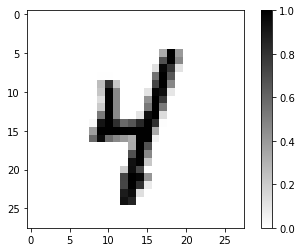

In [9]:
for imagen, etiqueta in datos_entrenamiento.take(1):
    break

import matplotlib.pyplot as plt
# Mostrarlo en pantalla
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.show()

In [16]:
print(imagen[15][15])
print(imagen[1][1])
print(imagen[5][19])

tf.Tensor([0.99215686], shape=(1,), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([0.39607844], shape=(1,), dtype=float32)


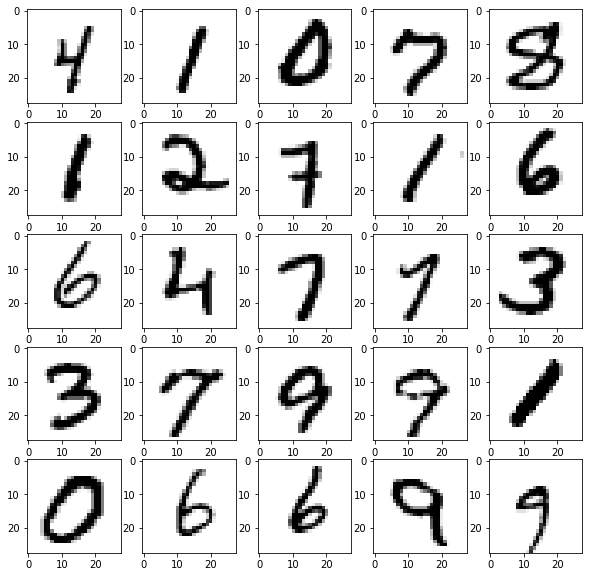

In [18]:
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
    plt.subplot(5, 5, i+1)
    plt.imshow(imagen, cmap=plt.cm.binary)

plt.show()

## Modelo

In [19]:
modelo = tf.keras.Sequential([
    # 784 datos de entrada
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)), # 1 = blanco y negro
    # # # Capa oculta
    tf.keras.layers.Dense(1),
    # Capas de salida
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    
])

In [20]:

modelo.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [21]:
# Hay que hacer un poco de preprocesamiento adicional, a diferencia del anterior que
# teníamos pocos datos, 7, ahora tenemos 70000 lo que hace que necesitemos hacer
# algunas optimizaciones para que funcione de manera correcta y no se le acabe la
# memoria ni se tarde tanto. Una de las opcines es especificar un tamaño.
TAMANO_LOTE = 32

datos_entrenamiento = datos_entrenamiento.repeat().shuffle(60000).batch(TAMANO_LOTE)
datos_prueba = datos_prueba.batch(TAMANO_LOTE)

In [22]:
import math

# Entrenar
entrenamiento = modelo.fit(
    datos_entrenamiento,
    epochs=10,
    steps_per_epoch=math.ceil(60000/TAMANO_LOTE)
)

Epoch 1/10
1875/1875 [==============================] - 2s 599us/step - loss: 1.7852 - accuracy: 0.2601
Epoch 2/10
1875/1875 [==============================] - 1s 587us/step - loss: 1.6598 - accuracy: 0.3081
Epoch 3/10
1875/1875 [==============================] - 1s 604us/step - loss: 1.6393 - accuracy: 0.3225
Epoch 4/10
1875/1875 [==============================] - 1s 594us/step - loss: 1.6226 - accuracy: 0.3426
Epoch 5/10
1875/1875 [==============================] - 1s 590us/step - loss: 1.6111 - accuracy: 0.3620
Epoch 6/10
1875/1875 [==============================] - 1s 618us/step - loss: 1.5950 - accuracy: 0.3699
Epoch 7/10
1875/1875 [==============================] - 1s 602us/step - loss: 1.5847 - accuracy: 0.3821
Epoch 8/10
1875/1875 [==============================] - 1s 596us/step - loss: 1.5689 - accuracy: 0.3963
Epoch 9/10
1875/1875 [==============================] - 1s 586us/step - loss: 1.5654 - accuracy: 0.4080
Epoch 10/10
1875/1875 [==============================] - 1s 589u

In [23]:

# Vemos resultados no muy prometedores, recordar que tenemos solo 1 neurona intermedia
# Hacemos algunos cambios y probamos...

modelo = tf.keras.Sequential([
    # 784 datos de entrada
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)), # 1 = blanco y negro
    # # # Capa oculta
    tf.keras.layers.Dense(50),
    tf.keras.layers.Dense(50),
    # Capas de salida
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    
])

modelo.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

# Entrenar
entrenamiento = modelo.fit(
    datos_entrenamiento,
    epochs=10,
    steps_per_epoch=math.ceil(60000/TAMANO_LOTE)
)

Epoch 1/10
1875/1875 [==============================] - 2s 780us/step - loss: 0.3652 - accuracy: 0.8950
Epoch 2/10
1875/1875 [==============================] - 2s 839us/step - loss: 0.2940 - accuracy: 0.9162
Epoch 3/10
1875/1875 [==============================] - 2s 886us/step - loss: 0.2923 - accuracy: 0.9171
Epoch 4/10
1875/1875 [==============================] - 2s 855us/step - loss: 0.2780 - accuracy: 0.9212
Epoch 5/10
1875/1875 [==============================] - 2s 862us/step - loss: 0.2840 - accuracy: 0.9215
Epoch 6/10
1875/1875 [==============================] - 2s 871us/step - loss: 0.2748 - accuracy: 0.9215
Epoch 7/10
1875/1875 [==============================] - 2s 848us/step - loss: 0.2698 - accuracy: 0.9253
Epoch 8/10
1875/1875 [==============================] - 2s 878us/step - loss: 0.2685 - accuracy: 0.9245
Epoch 9/10
1875/1875 [==============================] - 2s 843us/step - loss: 0.2684 - accuracy: 0.9244
Epoch 10/10
1875/1875 [==============================] - 2s 867u

In [24]:
# Vemos resultados más prometedores, pero recordemos que la función de activación 
# al no indicarla, es lineal por el momento, vamos a probar una no linea para dar
# o quitar esa caractetística al nuevo modelo. Es decir, que no sea forzosamente 
# lineal si no que pueda hacer todo tipo de cosas.
# Hacemos algunos cambios y probamos...

modelo = tf.keras.Sequential([
    # 784 datos de entrada
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)), # 1 = blanco y negro
    # # # Capa oculta
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    # Capas de salida
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    
])

modelo.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

# Entrenar
entrenamiento = modelo.fit(
    datos_entrenamiento,
    epochs=10,
    steps_per_epoch=math.ceil(60000/TAMANO_LOTE)
)

Epoch 1/10
1875/1875 [==============================] - 2s 825us/step - loss: 0.2930 - accuracy: 0.9146
Epoch 2/10
1875/1875 [==============================] - 2s 884us/step - loss: 0.1356 - accuracy: 0.9601
Epoch 3/10
1875/1875 [==============================] - 2s 873us/step - loss: 0.0981 - accuracy: 0.9706
Epoch 4/10
1875/1875 [==============================] - 2s 843us/step - loss: 0.0814 - accuracy: 0.9748
Epoch 5/10
1875/1875 [==============================] - 2s 871us/step - loss: 0.0654 - accuracy: 0.9792
Epoch 6/10
1875/1875 [==============================] - 2s 867us/step - loss: 0.0582 - accuracy: 0.9818
Epoch 7/10
1875/1875 [==============================] - 2s 848us/step - loss: 0.0491 - accuracy: 0.9845
Epoch 8/10
1875/1875 [==============================] - 2s 877us/step - loss: 0.0422 - accuracy: 0.9859
Epoch 9/10
1875/1875 [==============================] - 2s 863us/step - loss: 0.0387 - accuracy: 0.9876
Epoch 10/10
1875/1875 [==============================] - 2s 890u

1/1 [==============================] - 0s 10ms/step


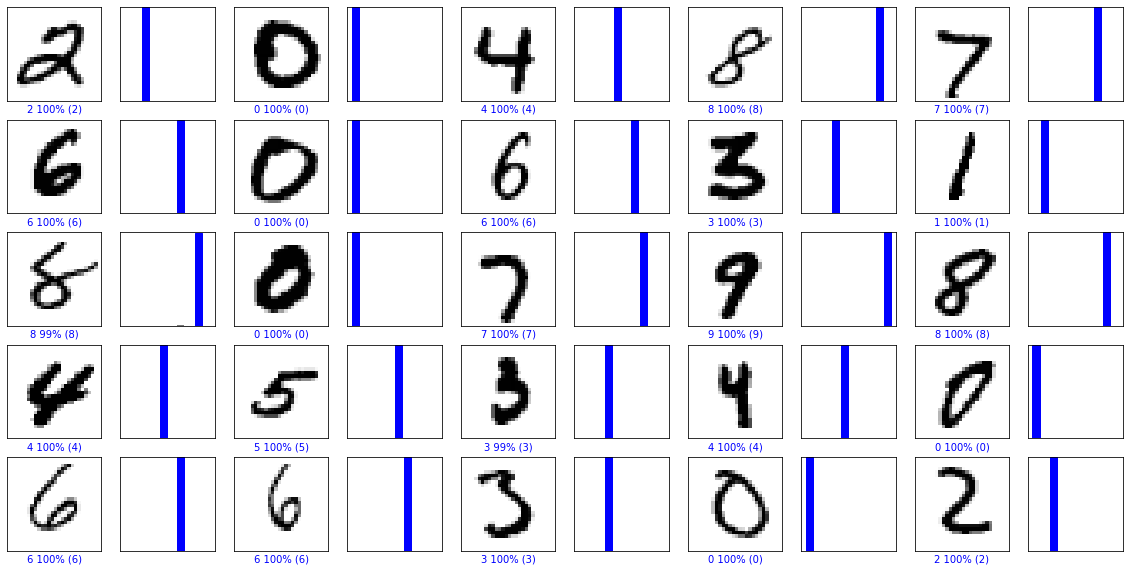

In [27]:

#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_prueba.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)
  
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)
  
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_prediccion = np.argmax(arr_predicciones)
  
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')
  
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)